<h1><center>Emotion-Robust Motor EEG Classification</center></h1>

### Imports

In [154]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import numpy as np
import gumpy
import mne

### Read Data

In [200]:
def read_data(subject):
    # First specify the location of the data and some 
    # identifier that is exposed by the dataset (e.g. subject)
    grazb_base_dir = '.\grazdata'
    subject = subject

    # The next line first initializes the data structure. 
    # Note that this does not yet load the data! In custom implementations
    # of a dataset, this should be used to prepare file transfers, 
    # for instance check if all files are available, etc.
    grazb_data = gumpy.data.GrazB(grazb_base_dir, subject)

    # Finally, load the dataset
    grazb_data.load()
    grazb_data.print_stats()
    labels=grazb_data.labels
    print(grazb_data.raw_data.shape, grazb_data.raw_data[0, :])
    
    return grazb_data, labels

In [231]:
data_subject_1, labels_1 = read_data('B05')

Data identification: GrazB-B05
EEG-data shape: (1762944, 3)
Trials data shape:  (382,)
Labels shape:  (382,)
Sampling frequency of EEG data: 250
Classes possible:  [0 1]
(1762944, 3) [0.58594644 4.73334859 6.31418326]


In [232]:
data_subject_2, labels_2 = read_data('B04')

Data identification: GrazB-B04
EEG-data shape: (1769628, 3)
Trials data shape:  (399,)
Labels shape:  (399,)
Sampling frequency of EEG data: 250
Classes possible:  [0 1]
(1769628, 3) [ 1.37636378  0.51880674 -2.1606775 ]


### Band-Pass Filtering
``gumpy`` ships with several filters already implemented. They accept either raw data to be filtered, or a subclass of ``Dataset``. In the latter case, ``gumpy`` will automatically convert all channels using parameters extracted from the dataset.

In [233]:
def band_pass_filter(grazb_data):
    # this returns a butter-bandpass filtered version of the entire dataset
    #bandpass
    lowcut=2
    highcut=60

    return gumpy.signal.butter_bandpass(grazb_data, lo=lowcut, hi=highcut)

In [234]:
btr_data_1 = band_pass_filter(data_subject_1)
btr_data_2 = band_pass_filter(data_subject_2)

### Artifact Removal
Usually it is necessary to postprocess the raw data before you can properly use it. ``gumpy`` provides several methods to easily do so, or provides implementations that can be adapted to your needs.

Most methods internally use other Python toolkits, for instance ``sklearn``, which is heavily used throughout ``gumpy``. Thereby, it is easy to extend ``gumpy`` with custom filters. In addition, we expect users to have to manipulate the raw data directly as shown in the following example.

#### ICA

In [351]:
# Good results for subject 1
reconsructed, sources = gumpy.signal.artifact_removal(data_subject_1.raw_data)
data_subject_1.raw_data = reconsructed

### Plotting
Certainly you wish to plot results. ``gumpy`` provides several functions that show how to implement visualizations. For this purpose it heavily relies on ``matplotlib``, ``pandas``, and ``seaborn``. The following examples will show several of the implemented signal processing methods as well as their corresponding plotting functions. Moreover, the examples will show you how to extract features

That said, let's start with a simple visualization where we access the filtered data from above to show you how to access the data and plot it.

In [352]:
def plot_data(btr_data, grazb_data):
    # Plot after filtering with a butter bandpass (ignore normalization)
    plt.figure()
    plt.clf()
    plt.plot(btr_data[grazb_data.trials[0]: grazb_data.trials[1], 0], label='C3')
    plt.plot(btr_data[grazb_data.trials[0]: grazb_data.trials[1], 1], alpha=0.7, label='C4')
    plt.plot(btr_data[grazb_data.trials[0]: grazb_data.trials[1], 2], alpha=0.7, label='Cz')
    plt.legend()
    plt.title(" Filtered Data")

#### Subject 1

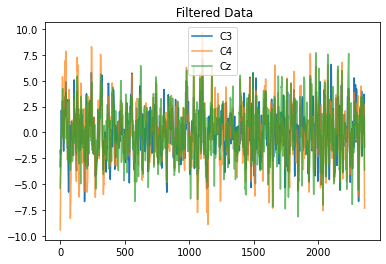

In [353]:
plot_data(btr_data_1, data_subject_1)

#### Subject 2

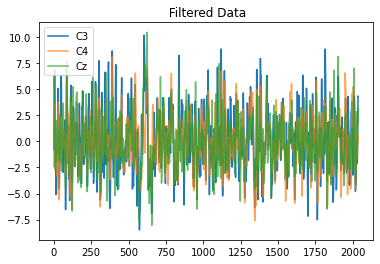

In [354]:
plot_data(btr_data_2, data_subject_2)

### EEG band visualization
Using ``gumpy``'s filters and the provided method, it is easy to filter and subsequently plot the  EEG bands of a trial.

In [238]:
def eeg_band_vis(grazb_data):
    # determine the trial that we wish to plot
    n_trial = 120
    # now specify the alpha and beta cutoff frequencies
    lo_a, lo_b = 7, 16
    hi_a, hi_b = 13, 24

    # first step is to filter the data
    flt_a = gumpy.signal.butter_bandpass(grazb_data, lo=lo_a, hi=hi_a)
    flt_b = gumpy.signal.butter_bandpass(grazb_data, lo=lo_b, hi=hi_b)

    # finally we can visualize the data
    gumpy.plot.EEG_bandwave_visualizer(grazb_data, flt_a, n_trial, lo_a, hi_a)
    gumpy.plot.EEG_bandwave_visualizer(grazb_data, flt_b, n_trial, lo_b, hi_b)
    
    return flt_a, flt_b

#### Subject 1

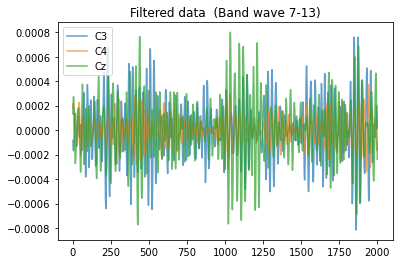

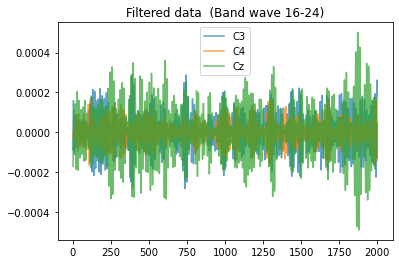

In [355]:
flt_a_1, flt_b_1 = eeg_band_vis(data_subject_1)

#### Subject 2

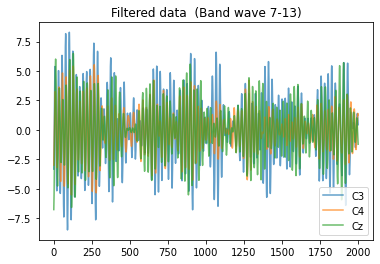

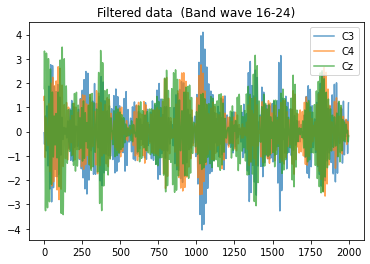

In [356]:
flt_a_2, flt_b_2 = eeg_band_vis(data_subject_2)

### Extract trials
Now we wish to extract the trials from the data. This operation may heavily depend on your dataset, and thus we cannot guarantee that the function works for your specific dataset. However, the used function ``gumpy.utils.extract_trials`` can be used as a guideline how to extract the trials you wish to examine.

In [166]:
def extract_trials(grazb_data, flt_a, flt_b):
    # retrieve the trials from the filtered data. This requires that the function
    # knows the number of trials, labels, etc. when only passed a (filtered) data matrix
    trials = grazb_data.trials
    labels = grazb_data.labels
    sampling_freq = grazb_data.sampling_freq
    data_class_a = gumpy.utils.extract_trials(flt_a, trials=trials, labels=labels, sampling_freq=sampling_freq)
    epochs = gumpy.utils.extract_trials(grazb_data, trials=trials, labels=labels, sampling_freq=sampling_freq)

    # it is also possible to pass an instance of Dataset and filtered data.
    # gumpy will then infer all necessary details from the dataset
    data_class_b = gumpy.utils.extract_trials(grazb_data, flt_b)
    

    # similar to other functions, this one allows to pass an entire instance of Dataset
    # to operate on the raw data
    data_class1 = gumpy.utils.extract_trials(grazb_data)

    
    return data_class_a, data_class_b

In [167]:
data_class_a_1, data_class_b_1 = extract_trials(data_subject_1, flt_a_1, flt_b_1)
data_class_a_2, data_class_b_2 = extract_trials(data_subject_2, flt_a_2, flt_b_2)

### Feature extraction

#### Method 1: Logarithmic sub-band power
The following examples show how the sub-bands can be used to extract features. This also shows how the fields of the dataset can be accessed, and how to write methods specific to your data using a mix of gumpy's and numpy's functions.

####  Alpha and Beta sub-bands
Using `gumpy`'s functions you can quickly define feature extractors. The following examples will demonstrate how you can use the predefined filters

In [241]:
def alpha_subBP_features(data):
    # filter data in sub-bands by specification of low- and high-cut frequencies
    alpha1 = gumpy.signal.butter_bandpass(data, 8.5, 11.5, order=4)
    alpha2 = gumpy.signal.butter_bandpass(data, 9.0, 12.5, order=4)
    alpha3 = gumpy.signal.butter_bandpass(data, 9.5, 11.5, order=4)
    alpha4 = gumpy.signal.butter_bandpass(data, 8.0, 10.5, order=4)

    # return a list of sub-bands
    return [alpha1, alpha2, alpha3, alpha4]

def beta_subBP_features(data):
    beta1 = gumpy.signal.butter_bandpass(data, 14.0, 30.0, order=4)
    beta2 = gumpy.signal.butter_bandpass(data, 16.0, 17.0, order=4)
    beta3 = gumpy.signal.butter_bandpass(data, 17.0, 18.0, order=4)
    beta4 = gumpy.signal.butter_bandpass(data, 18.0, 19.0, order=4)
    return [beta1, beta2, beta3, beta4]

In [357]:
alpha_bands_1 = np.array(alpha_subBP_features(data_subject_1))
beta_bands_1 = np.array(beta_subBP_features(data_subject_1))

In [358]:
alpha_bands_2 = np.array(alpha_subBP_features(data_subject_2))
beta_bands_2 = np.array(beta_subBP_features(data_subject_2))

#### Log sub-band power

In [214]:
def powermean(data, trial, fs, w):
    return np.power(data[trial+fs*4+w[0]: trial+fs*4+w[1],0],2).mean(), \
           np.power(data[trial+fs*4+w[0]: trial+fs*4+w[1],1],2).mean(), \
           np.power(data[trial+fs*4+w[0]: trial+fs*4+w[1],2],2).mean()

def log_subBP_feature_extraction(alpha, beta, trials, fs, w):
    # number of features combined for all trials
    n_features = 24
    # initialize the feature matrix
    X = np.zeros((len(trials), n_features))
    
    # Extract features
    for t, trial in enumerate(trials):
        power_c31, power_c41, power_cz1 = powermean(alpha[0], trial, fs, w)
        power_c32, power_c42, power_cz2 = powermean(alpha[1], trial, fs, w)
        power_c33, power_c43, power_cz3 = powermean(alpha[2], trial, fs, w)
        power_c34, power_c44, power_cz4 = powermean(alpha[3], trial, fs, w)
        power_c31_b, power_c41_b, power_cz1_b = powermean(beta[0], trial, fs, w)
        power_c32_b, power_c42_b, power_cz2_b = powermean(beta[1], trial, fs, w)
        power_c33_b, power_c43_b, power_cz3_b = powermean(beta[2], trial, fs, w)
        power_c34_b, power_c44_b, power_cz4_b = powermean(beta[3], trial, fs, w)
        
        X[t, :] = np.array(
            [np.log(power_c31), np.log(power_c41), np.log(power_cz1),
             np.log(power_c32), np.log(power_c42), np.log(power_cz2),
             np.log(power_c33), np.log(power_c43), np.log(power_cz3), 
             np.log(power_c34), np.log(power_c44), np.log(power_cz4),
             np.log(power_c31_b), np.log(power_c41_b), np.log(power_cz1_b),
             np.log(power_c32_b), np.log(power_c42_b), np.log(power_cz2_b),
             np.log(power_c33_b), np.log(power_c43_b), np.log(power_cz3_b),
             np.log(power_c34_b), np.log(power_c44_b), np.log(power_cz4_b)])

    return X

In [245]:
def get_subBP_features(grazb_data, alpha_bands, beta_bands):
    w1 = [0,125]
    w2 = [125,250]

    features1 = log_subBP_feature_extraction(
        alpha_bands, beta_bands, 
        grazb_data.trials, grazb_data.sampling_freq,
        w1)

    features2 = log_subBP_feature_extraction(
        alpha_bands, beta_bands, 
        grazb_data.trials, grazb_data.sampling_freq,
        w2)                                          
        
    
    features_alpha = np.concatenate((features1[:, :12], features2[:, :12]), axis=1)
    features_beta = np.concatenate((features1[:, 12:], features2[:, 12:]), axis=1)
    
    
    # concatenate the features and normalize the data
    features = np.concatenate((features_alpha.T, features_beta.T)).T
    features -= np.mean(features)
    features = gumpy.signal.normalize(features, 'min_max')

    # print shape to quickly check if everything is as expected
    print("Features shape: ", features.shape)
    
    return features

In [359]:
features_1 = get_subBP_features(data_subject_1, alpha_bands_1, beta_bands_1)
features_2 = get_subBP_features(data_subject_2, alpha_bands_2, beta_bands_2)

Features shape:  (382, 48)
Features shape:  (399, 48)


#### Method 2: Common Spatial Pattern

In [ ]:
def extract_trials_class1(raw_data, trials, W1, W2):

    # init data lists for each class 
    #(n_trials,          n_samples,      n_channels)
    class1_data = np.zeros((len(np.where(labels==0)[0]), 250*1, len(raw_data[0,:])))

    # split data class 1
    for i, c1_idx in enumerate(range(len(np.where(labels==0)[0]))):   # iterate over trials
        class1_data[i,:,:] = raw_data[trials[c1_idx]+W1 : trials[c1_idx]+W2] 
    return class1_data

def extract_trials_class2(raw_data, trials, W1, W2):

    # init data lists for each class 
    #(n_trials,          n_samples,      n_channels)
    class1_data = np.zeros((len(np.where(labels==1)[0]), 250*1, len(raw_data[0,:])))

    # split data class 1
    for i, c1_idx in enumerate(range(len(np.where(labels==1)[0]))):   # iterate over trials
        class1_data[i,:,:] = raw_data[trials[c1_idx]+W1 : trials[c1_idx]+W2] 
    return class1_data



def extract_matching_trials(l, trials ):
    trials0=[]
    for i in range (len(np.where(labels==l)[0])): 
        trials0.append(trials[np.where(labels==l)[0][i]]) 
    return trials0



    
trials0=extract_matching_trials(0, grazb_data.trials )
trials1=extract_matching_trials(1, grazb_data.trials )


epochs12=extract_trials_class1(btr_data, trials0, 250*4, 250*5)
epochs13=extract_trials_class1(btr_data, trials0, 250*5, 250*6)
#epochs14=extract_trials_class1(btr_data, trials0, 250*6, 250*7)'
# epochs_0= np.concatenate((epochs12, epochs13))
epochs_0= np.concatenate((epochs12, epochs13))
epochs_0 = np.swapaxes(epochs_0,2,1) 
print(epochs_0.shape)


epochs22=extract_trials_class2(btr_data, trials1, 250*4, 250*5)
epochs23=extract_trials_class2(btr_data, trials1, 250*5, 250*6)
#epochs24=extract_trials_class2(btr_data, trials1, 250*6, 250*7)
# epochs_1= np.concatenate((epochs22, epochs23))
epochs_1= np.concatenate((epochs22, epochs23))
epochs_1 = np.swapaxes(epochs_1,2,1) 
print(epochs_1.shape)



def labelling_class0 (label): 
    y=[]
    for i in range(0, len(np.where(labels==0)[0])*2):
           y.append(label)
    return y 
                   
def labelling_class1 (label): 
    y=[]
    for i in range(0, len(np.where(labels==1)[0])*2):
           y.append(label)
    return y 

label_0=labelling_class0(0)
label_1=labelling_class1(1)


epochs_re = np.concatenate((epochs_0, epochs_1), axis=0)
print("Dataset:", epochs_re.shape)

# Update the label vector
# Update the label vector
labels= np.concatenate((label_0, label_1))

# Split data

import scipy.linalg as la
def extract_features(epoch, spatial_filter):
    feature_matrix = np.dot(spatial_filter, epoch)
    variance = np.var(feature_matrix, axis=1)
    if np.all(variance == 0):
        return np.zeros(spatial_filter.shape[0])
    features = np.log(variance/np.sum(variance))
    return features

def select_filters(filters, num_components = None, verbose = False):
    if verbose:
        print("Incomming filters:", filters.shape, "\nNumber of components:", num_components if num_components else " all")
    if num_components == None:
        return filters
    assert num_components <= filters.shape[0]/2, "The requested number of components is too high"
    selection = list(range(0, num_components)) + list(range(filters.shape[0] - num_components, filters.shape[0]))
    reduced_filters = filters[selection,:]
    return reduced_filters

# Select the number of used spatial components
n_components = None; # assign None for all components

def CSP(tasks):
    """This function extracts Common Spatial Pattern (CSP) features.
    Args:
        For N tasks, N arrays are passed to CSP each with dimensionality (# of
        trials of task N) x (feature vector)
    Returns:
        A 2D CSP features matrix.
    """
    if len(tasks) < 2:
        print("Must have at least 2 tasks for filtering.")
        return (None,) * len(tasks)
    else:
        filters = ()
        iterator = range(0,len(tasks))
        for x in iterator:
			# Find Rx
            Rx = covarianceMatrix(tasks[x][0])
            for t in range(1,len(tasks[x])):
                Rx += covarianceMatrix(tasks[x][t])
                Rx = Rx / len(tasks[x])

			# Find not_Rx
            count = 0
            not_Rx = Rx * 0
            for not_x in [element for element in iterator if element != x]:
                for t in range(0,len(tasks[not_x])):
                    not_Rx += covarianceMatrix(tasks[not_x][t])
                    count += 1
                not_Rx = not_Rx / count

			# Find the spatial filter SFx
            SFx = spatialFilter(Rx,not_Rx)
            filters += (SFx,)

			# Special case: only two tasks, no need to compute any more mean variances
            if len(tasks) == 2:
                filters += (spatialFilter(not_Rx,Rx),)
                break
    return filters


# covarianceMatrix takes a matrix A and returns the covariance matrix, scaled by the variance
def covarianceMatrix(A):
    """This function computes the covariance Matrix
    Args:
        A: 2D matrix
    Returns:
        A 2D covariance matrix scaled by the variance
    """
	#Ca = np.dot(A,np.transpose(A))/np.trace(np.dot(A,np.transpose(A)))
    Ca = np.cov(A)
    return Ca


def spatialFilter(Ra,Rb):
    R = Ra + Rb
    E,U = la.eig(R)

# CSP requires the eigenvalues E and eigenvector U be sorted in descending order
    ord = np.argsort(E)
    ord = ord[::-1] # argsort gives ascending order, flip to get descending
    E = E[ord]
    U = U[:,ord]

	# Find the whitening transformation matrix
    P = np.dot(np.sqrt(la.inv(np.diag(E))),np.transpose(U))
    
    # The mean covariance matrices may now be transformed
    Sa = np.dot(P,np.dot(Ra,np.transpose(P)))
    Sb = np.dot(P,np.dot(Rb,np.transpose(P)))
    
	# Find and sort the generalized eigenvalues and eigenvector
    E1,U1 = la.eig(Sa,Sb)
    ord1 = np.argsort(E1)
    ord1 = ord1[::-1]
    E1 = E1[ord1]
    U1 = U1[:,ord1]

	# The projection matrix (the spatial filter) may now be obtained
    SFa = np.dot(np.transpose(U1),P)
	#return SFa.astype(np.float32)
    return SFa

tasks=(epochs_re[np.where(labels==0)], epochs_re[np.where(labels==1)])

if True:    
    #Generate the spacial filterns for the training data
    temp_filters = np.asarray(CSP(tasks))

    spatial_filter = select_filters(temp_filters[0], n_components)
    #print(spatial_filter.shape)
    
    # Extract the CSPs
    features = np.array([extract_features(epoch, spatial_filter) for epoch in epochs_re])
    
features.shape

### Split Data

In [360]:
def split_dataset(features, labels):
    split_features = np.array(gumpy.split.normal(features, labels,test_size=0.2))
    X_train = split_features[0]
    X_test = split_features[1]
    Y_train = split_features[2]
    Y_test = split_features[3]
    
    return X_train, X_test, Y_train, Y_test

In [361]:
X_train_1, X_test_1, Y_train_1, Y_test_1 = split_dataset(features_1, labels_1)
X_train_2, X_test_2, Y_train_2, Y_test_2 = split_dataset(features_2, labels_2)

### Plot features with PCA

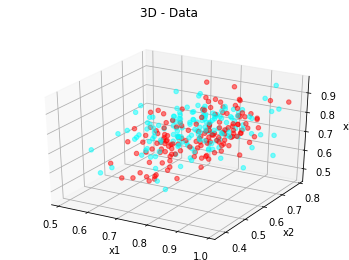

In [364]:
gumpy.plot.PCA("3D", features_1, X_train_1, Y_train_1)

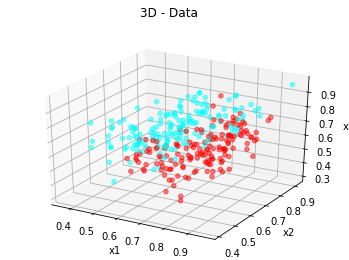

In [365]:
gumpy.plot.PCA("3D", features_2, X_train_2, Y_train_2)

### Normalize Data

In [366]:
def normalize_data(X_train, X_test):
    # normalize the data first
    X_train = gumpy.signal.normalize(X_train, 'mean_std')
    X_train = gumpy.signal.normalize(X_train, 'min_max')
    X_test = gumpy.signal.normalize(X_test, 'mean_std')
    X_test = gumpy.signal.normalize(X_test, 'min_max')

    # let's see some statistics
    print("""Normalized Data:
      Mean    = {:.3f}
      Min     = {:.3f}
      Max     = {:.3f}
      Std.Dev = {:.3f}""".format(
      np.nanmean(X_train),np.nanmin(X_train),np.nanmax(X_train),np.nanstd(X_train)
    ))
    
    return X_train, X_test

In [367]:
X_train_1, X_test_1 = normalize_data(X_train_1, X_test_1)

Normalized Data:
      Mean    = 0.573
      Min     = 0.000
      Max     = 1.000
      Std.Dev = 0.116


In [368]:
X_train_2, X_test_2 = normalize_data(X_train_2, X_test_2)

Normalized Data:
      Mean    = 0.611
      Min     = 0.000
      Max     = 1.000
      Std.Dev = 0.126


#### Fisher score for alpha and beta
First 24 indices belong to alpha sub band while the remaining 24 belong to beta

In [181]:
from skfeature.function.similarity_based import fisher_score

score = fisher_score.fisher_score(X_train_1, Y_train_1)
score

array([21, 32, 44, 30, 12, 42,  9, 29, 35, 39, 11,  0,  8, 45, 47, 26, 41,
       27, 14, 10,  2, 24,  6,  3, 33,  7, 19, 25, 38, 43, 13, 36, 15, 22,
        5, 16, 18, 17, 28, 34,  4, 37, 20,  1, 31, 46, 40, 23])

### Train Motor-EEG Classifier

#### Available Classifiers

In [182]:
gumpy.classification.available_classifiers

{'SVM': gumpy.classification.common.SVM,
 'KNN': gumpy.classification.common.KNN,
 'LDA': gumpy.classification.common.LDA,
 'Tree': gumpy.classification.common.Tree,
 'LogisticRegression': gumpy.classification.common.LogisticRegression,
 'MLP': gumpy.classification.common.MLP,
 'NaiveBayes': gumpy.classification.common.NaiveBayes,
 'RandomForest': gumpy.classification.common.RandomForest,
 'QuadraticLDA': gumpy.classification.common.QuadraticLDA,
 'ShrinkingLDA': gumpy.classification.common.ShrinkingLDA}

In [254]:
def train_classifier(X_train, X_test, Y_train, Y_test, clf_type):
    if clf_type == "Voting":
        result, clf = gumpy.classification.vote(X_train, Y_train, X_test, Y_test, 'hard', False, (6,12))
    else:
        result, clf = gumpy.classify(clf_type, X_train, Y_train, X_test, Y_test)
    
    print("Classification result for soft voting classifier")
    print(result)
    print("Accuracy: ", result.accuracy)
    
    return clf

In [369]:
motor_clf_1 = train_classifier(X_train_1, X_test_1, Y_train_1, Y_test_1, 'Voting')

Classification result for soft voting classifier
              precision    recall  f1-score   support

           0       0.69      0.78      0.73        45
           1       0.62      0.50      0.55        32

    accuracy                           0.66        77
   macro avg       0.65      0.64      0.64        77
weighted avg       0.66      0.66      0.66        77

Accuracy:  66.23376623376623


In [266]:
motor_clf_2 = train_classifier(X_train_2, X_test_2, Y_train_2, Y_test_2, 'Voting')

Classification result for soft voting classifier
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        44
           1       0.91      0.89      0.90        36

    accuracy                           0.91        80
   macro avg       0.91      0.91      0.91        80
weighted avg       0.91      0.91      0.91        80

Accuracy:  91.25


## Cross-Subject Classification

### Label data for each subject

In [370]:
# Label '0' for subject 1
Y_train_1_xs = Y_train_1.copy()
Y_train_1_xs.fill(0)
Y_test_1_xs = Y_test_1.copy()
Y_test_1_xs.fill(0)

# Label '1' for subject 2
Y_train_2_xs = Y_train_2.copy()
Y_train_2_xs.fill(1)
Y_test_2_xs = Y_test_2.copy()
Y_test_2_xs.fill(1)

### Combine datasets

In [371]:
X_train_C = np.concatenate((X_train_1, X_train_2))
X_test_C = np.concatenate((X_test_1, X_test_2))
Y_train_C = np.concatenate((Y_train_1_xs, Y_train_2_xs))
Y_test_C = np.concatenate((Y_test_1_xs, Y_test_2_xs))

### Train classifier

In [372]:
result, clf_C = gumpy.classification.vote(X_train_C, Y_train_C, X_test_C, Y_test_C, 'soft', False, (6,12))

### Test classifier

In [373]:
from scipy.stats import mode

In [374]:
# subject 1 test run
results_1 = []
for i in range(0, 65, 5):
    results_1.append(mode(clf_C.predict(X_test_1[i:i+5, :]))[0][0])

In [375]:
# subject 2 test run
results_2 = []
for i in range(0, 80, 5):
    results_2.append(mode(clf_C.predict(X_test_2[i:i+5, :]))[0][0])

In [376]:
results_1, results_2

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0])

In [377]:
def score_cross_sub_classifier(results, gt):
    sum = 0
    for i in results:
        sum = sum + 1 if i==gt else sum + 0
    
    return sum/len(results)

In [378]:
print("Test Accuracy: ", (score_cross_sub_classifier(results_1, 0) + score_cross_sub_classifier(results_2, 1)) / 2.0)

Test Accuracy:  0.6875


#### Test different classifiers

In [284]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
clf_C = LogisticRegression(random_state=0).fit(X_train_C, Y_train_C)

In [290]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf_C = LinearDiscriminantAnalysis().fit(X_train_C, Y_train_C)

In [296]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
clf_C = GaussianNB().fit(X_train_C, Y_train_C)

#### t-SNE for features

In [212]:
from sklearn.manifold import TSNE
def get_tsne_embeddings(data, dim=3):
    X_embedded = TSNE(n_components=dim).fit_transform(data)
    return X_embedded

In [213]:
X_train_1 = get_tsne_embeddings(X_train_1)
X_test_1 = get_tsne_embeddings(X_test_1)
X_train_2 = get_tsne_embeddings(X_train_2)
X_test_2 = get_tsne_embeddings(X_test_2)